In [1]:
# Import various python packages

import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation as icc
from iris.time import PartialDateTime
import iris.util as iutil

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import cartopy.crs as ccrs

import os
import warnings 

import cartopy.io.shapereader as shpreader

import cartopy.feature as cfeature
import matplotlib.path as mpath
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D

warnings.filterwarnings('ignore') 

In [2]:
import sys
sys.path.append('..')

from Cube_Functions import *
from Plot_Functions import *
from Climate_Functions import *
from Stats_Functions import *
print('Finished loading libraries and functions')

#clean up namespace
del sys

Finished loading libraries and functions


In [3]:
experiment = 'lig127k'
control = 'piControl'

root_path = '/gws/nopw/j04/pmip4_vol1/public/matt/data/'

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

var = 'tas'


In [20]:

from pathlib import Path

models_with_files = []
#for every folder in the root path
exp_matches = None
con_matches = None
for folder in os.listdir(root_path):
    #if the folder is a directory and contains the experiment
    print(folder)
    if os.path.isdir(os.path.join(root_path, folder, experiment)):
        #print(f'Found {experiment} folder: {folder}')
        #check if there's a file like *_tas_*.nc in the experiment folder
        exp_path = os.path.join(root_path, folder, experiment)
        exp_matches = list(Path(exp_path).glob("tas_*.nc"))
        if exp_matches:
            print(f"Found {experiment}:", len(exp_matches), " files")
        else:
            print("No matching files")
    if os.path.isdir(os.path.join(root_path, folder, control)):
        #print(f'Found {experiment} folder: {folder}')
        #check if there's a file like *_tas_*.nc in the experiment folder
        con_path = os.path.join(root_path, folder, control)
        con_matches = list(Path(con_path).glob("tas_*.nc"))
        if con_matches:
            print(f"Found {control}:", len(con_matches), " files")
        else:
            print("No matching files")
    if exp_matches and con_matches:
        models_with_files.append(folder)
        print(f"Found both {experiment} and {control} for model: {folder}")
print(f"Models with files: {models_with_files}")

.ipynb_checkpoints
ACCESS-ESM1-5
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: ACCESS-ESM1-5
CESM2
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: CESM2
CNRM-CM6-1
No matching files
No matching files
EC-Earth3
No matching files
No matching files
EC-Earth3-LR
No matching files
No matching files
FGOALS-g3
IPSL-CM6A-LR
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: IPSL-CM6A-LR
MIROC-ES2L
No matching files
No matching files
NESM3
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: NESM3
NorESM1-F
No matching files
No matching files
NorESM2-LM
Found lig127k: 1  files
Found piControl: 1  files
Found both lig127k and piControl for model: NorESM2-LM
Models with files: ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'NESM3', 'NorESM2-LM']


In [29]:

models = models_with_files

In [5]:

con = iris.Constraint(latitude=lambda lat: 59.5 <= lat <= 90)

time_con = iris.Constraint(year=lambda y:np.logical_and(y>=2035,y<2045))  #time_constraint. Not used anywhere yet.

ocean_shp_reader = shpreader.Reader(shpreader.natural_earth(resolution="110m", category="physical", name="ocean"))
ocean_list = []
for ocean in ocean_shp_reader.records():
    ocean_list.append(ocean.geometry)
ocean_shp = ocean_list[1]

shape = ocean_shp

shape = None

In [56]:
#Proxy data from https://doi.org/10.5194/cp-19-883-2023
point_lats = [55,55,61,68,68,70,73.33,63,64,66,67,67,67.5,69,69,71.75,76.35]#,73,73,75,76.4]
point_lons = [18, -3, 152.5, 80, 160, -72.5, 141.5, -66, -150, -69.2, -160, -62, 172.08, -151, -133, -23, -68.3]#, -25, -38, -42, -44.8]
point_vals = [3.4,2.4,6.4,5.4,6.4,4.9,4.9,5.4,1.4,4.9,1.9,5.9,3.4,1.9,2.4,5.4,4.4]#,5.4,5.4,5.4,8]
point_markers = ['^','^','^','^','^','^','^','d','d','d','d','d','d','d','d','o','o']#,'*','*','*','*']
point_sizes=[30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30]#,50,50,50,50]

#combine proxy data into a dictionary
proxy_data = {
    'point_lats': point_lats,
    'point_lons': point_lons,
    'point_vals': point_vals,
    'point_markers': point_markers,
    'point_sizes': point_sizes
}

#create a dict of the proxy values in the same format as proxy_model_data
proxy_values_dict = {}
for i in range(len(point_lats)):
    lat = point_lats[i]
    lon = point_lons[i]
    val = point_vals[i]
    proxy_values_dict[(lat,lon)] = val
print('Finished creating proxy values dictionary')

Finished creating proxy values dictionary


In [7]:
def create_dict(simulation):
    var_dict={}
    for model in models:
        print('Processing '+model)
        var_dict[model] = {}
        path = create_path(model, simulation, var, root_path)
        cube = get_cube(path, var, con, shape)
        monthly_data = get_monthly_data(cube, 'MEAN')
        var_dict[model]['monthly_data'] = monthly_data
        var_dict[model]['cube'] = cube

        #create cube of monthly means
        monthly_means = []
        for month in range(1,13):
            month_con = iris.Constraint(month_number=month)
            month_cube = cube.extract(month_con)
            month_mean = month_cube.collapsed('time', iris.analysis.MEAN)
            monthly_means.append(month_mean)
        var_dict[model]['monthly_means'] = monthly_means
    return var_dict


In [27]:

def harmonise_lat_lon_bounds(c1, c2, tol=1e-10, coords=("latitude", "longitude")):
    """
    Make coordinate bounds consistent between two Iris cubes for the given coords.

    Strategy per coord:
      1) Require coord points to match (within tol) — otherwise raise (needs regridding/alignment).
      2) If one cube has bounds and the other doesn't, copy bounds across.
      3) If both have bounds but differ (within tol), overwrite c2 bounds with c1 bounds.

    Parameters
    ----------
    c1, c2 : iris.cube.Cube
        Cubes to be made compatible for arithmetic.
    tol : float
        Absolute tolerance for np.allclose comparisons.
    coords : tuple[str]
        Coordinate names to harmonise (default: ('latitude','longitude')).
    """
    for cname in coords:
        coord1 = c1.coord(cname)
        coord2 = c2.coord(cname)

        # Check points match
        if coord1.shape != coord2.shape or not np.allclose(coord1.points, coord2.points, atol=tol, rtol=0):
            raise ValueError(
                f"Coordinate points differ for '{cname}' (shapes {coord1.shape} vs {coord2.shape}). "
                "Regrid/align before arithmetic."
            )

        b1 = coord1.bounds
        b2 = coord2.bounds

        # Nothing to do
        if b1 is None and b2 is None:
            continue

        # Copy bounds if missing on one side
        if b1 is None and b2 is not None:
            coord1.bounds = b2.copy()
            continue

        if b2 is None and b1 is not None:
            coord2.bounds = b1.copy()
            continue

        # Both have bounds: reconcile if different
        if not np.allclose(b1, b2, atol=tol, rtol=0):
            coord2.bounds = b1.copy()


In [22]:
experiment_var_dict = create_dict(experiment)
control_var_dict = create_dict(control)


Processing ACCESS-ESM1-5
Processing CESM2
Processing IPSL-CM6A-LR
Processing NESM3
Processing NorESM2-LM
Processing ACCESS-ESM1-5
Processing CESM2
Processing IPSL-CM6A-LR
Processing NESM3
Processing NorESM2-LM


In [ ]:

anomaly_var_dict = {}
for model in models:
    print('Calculating anomalies for '+model)
    anomaly_var_dict[model] = {}
    experiment_monthly_data = experiment_var_dict[model]['monthly_data']
    control_monthly_data = control_var_dict[model]['monthly_data']
    anomaly_monthly_data = experiment_monthly_data - control_monthly_data
    anomaly_var_dict[model]['monthly_data'] = anomaly_monthly_data

    experiment_monthly_means = experiment_var_dict[model]['monthly_means']
    control_monthly_means = control_var_dict[model]['monthly_means']
    anomaly_monthly_means = []
    for month in range(12):
        e = experiment_monthly_means[month]
        c = control_monthly_means[month]

        harmonise_lat_lon_bounds(e, c)

        anomaly_month_mean = e - c
        anomaly_monthly_means.append(anomaly_month_mean)
    anomaly_var_dict[model]['monthly_means'] = anomaly_monthly_means
    jun_cube = anomaly_var_dict[model]['monthly_means'][5]
    jul_cube = anomaly_var_dict[model]['monthly_means'][6]
    aug_cube = anomaly_var_dict[model]['monthly_means'][7]
    summer_cube = (jun_cube + jul_cube + aug_cube) / 3.0
    anomaly_var_dict[model]['summer_mean'] = summer_cube

    model_vals = []
    anomaly_var_dict[model]['point_vals'] = {}
    for i in range(len(point_lats)):
        lat = point_lats[i]
        lon = point_lons[i]
        model_cube = anomaly_var_dict[model]['summer_mean'].copy()
        model_point_cube = model_cube.interpolate([('latitude', lat), ('longitude', lon)], iris.analysis.Linear())
        model_point_val = model_point_cube.data.item()
        #model_vals.append(model_point_val)
        anomaly_var_dict[model]['point_vals'][(lat,lon)] = model_point_val
    
print('Finished calculating anomalies')



In [69]:
#reformat point values into a dictionary of model: [list of point values]
model_point_dict = {}
for model in models:
    model_point_dict[model] = list(anomaly_var_dict[model]['point_vals'].values())

proxy_point_vals = list(point_vals)

print('Finished creating model point data dictionary')

Finished creating model point data dictionary


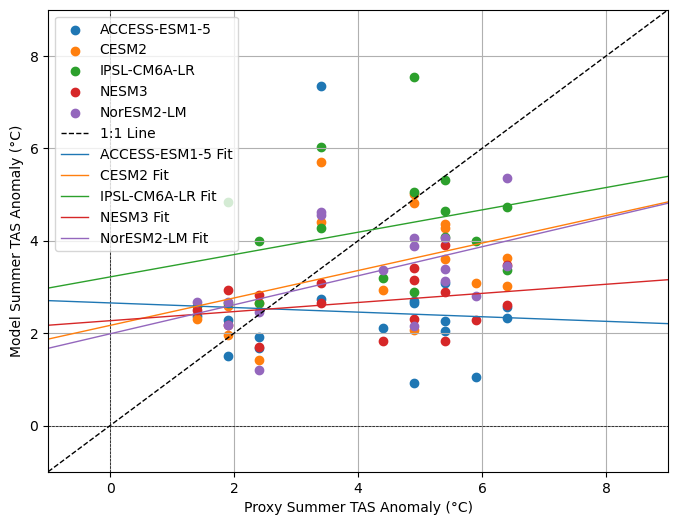

In [70]:
#for each model, plot the point_vals vs the proxy values
fig = plt.figure(figsize=(8,6))
for model in models:
    model_point_vals = model_point_dict[model]
    plt.scatter(proxy_point_vals, model_point_vals, label=model)
plt.xlabel('Proxy Summer TAS Anomaly (°C)')
plt.ylabel('Model Summer TAS Anomaly (°C)')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
#make sure axes are equal
plt.xlim(-1,9)
plt.ylim(-1,9)

#plot 1:1 line
plt.plot([-1,9], [-1,9], color='k', linestyle='--', linewidth=1, label='1:1 Line')

#for each model, plot linear regression line
for model in models:
    model_point_vals = []
    proxy_point_vals = []
    for i in range(len(point_lats)):
        lat = point_lats[i]
        lon = point_lons[i]
        model_val = anomaly_var_dict[model]['point_vals'][(lat,lon)]
        proxy_val = proxy_values_dict[(lat,lon)]
        model_point_vals.append(model_val)
        proxy_point_vals.append(proxy_val)
    #linear regression
    m, b = np.polyfit(proxy_point_vals, model_point_vals, 1)
    x = np.array([-1,9])
    y = m * x + b
    plt.plot(x, y, linestyle='-', linewidth=1, label=f'{model} Fit')

plt.legend()
plt.grid()
plt.show()


In [40]:
def calculate_rmse(model_point_vals, proxy_point_vals):
    model_point_vals = np.array(model_point_vals)
    proxy_point_vals = np.array(proxy_point_vals)
    rms_error = np.sqrt(np.mean((model_point_vals - proxy_point_vals)**2))
    return rms_error

In [62]:
#for each model, calculate the RMSE between the model point vals and the proxy point vals
rmse_dict = {}
for model in models:
    model_point_vals = model_point_dict[model]
    model_point_vals = np.array(model_point_vals)
    proxy_point_vals = np.array(proxy_point_vals)
    rmse = calculate_rmse(proxy_point_vals, model_point_vals)
    rmse_dict[model] = rmse
    print(f'Model: {model}, RMSE: {rmse:.2f} °C')

Model: ACCESS-ESM1-5, RMSE: 2.77 °C
Model: CESM2, RMSE: 1.74 °C
Model: IPSL-CM6A-LR, RMSE: 1.74 °C
Model: NESM3, RMSE: 2.16 °C
Model: NorESM2-LM, RMSE: 1.67 °C


In [ ]:

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
qplt.pcolormesh(summer_cube, cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)
plt.title('Summer Mean Surface Air Temperature - '+models[0])
plt.show()